In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchvision
import matplotlib.pyplot as plt
from preprocess import get_raw_data, get_batch_generator
from datasets import load_from_disk
import os
import csv
import torch
from tqdm import tqdm

In [2]:
dataset = load_from_disk("audio")

In [3]:
SR = 12000

signals_train, labels_train, sizes_train = get_raw_data(dataset["train"])
signals_test, labels_test, sizes_test = get_raw_data(dataset["test"])


In [4]:
# **Dataset to load audio file. Implement mixup transform**
class AudioDataset(Dataset):
    def __init__(self, X, y, mean, std, n_mels, n_fft, hop_length, mixup=False):
        
        self.X = X
        self.labels = y
        self.sample_rate = 12000
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )

        self.env_idx = np.where(self.labels == 1)[0]
        self.mixup = mixup
        self.mean = mean
        self.std = std
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        waveform = self.X[idx]
        if self.mixup:
            r = np.random.random()
            if r > 0.5:
                idx_to_add = np.random.choice(self.env_idx)
                to_add = self.X[idx_to_add]
                #r *= 2
                assert (r <= 1)
                waveform = r*waveform + (1-r)*to_add

        waveform = torch.as_tensor(waveform).unsqueeze(0)

        mel_spectrogram = self.mel_transform(waveform)
        mel_spectrogram = torch.log10(1+mel_spectrogram)
        
        # Normaliser le spectrogramme
        mel_spectrogram = (mel_spectrogram - self.mean)/self.std
        
        return mel_spectrogram, self.labels[idx]

def train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    num_epochs, 
    device, 
    save_dir="checkpoints", 
    csv_file="validation_accuracy.csv"
):
    # Préparer le dossier de sauvegarde
    os.makedirs(save_dir, exist_ok=True)

    # Préparer le fichier CSV
    if not os.path.exists(csv_file):
        with open(csv_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["epoch", "val_accuracy"])  # En-têtes du CSV

    model = model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float).view(-1)  # Labels en 1D pour BCEWithLogitsLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).view(-1)  # Sorties en 1D pour BCEWithLogitsLoss
                    loss = criterion(outputs, labels)  # Calcul de la perte
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)

                # Calcul des prédictions binaires (sigmoid + seuil 0.5)
                preds = torch.sigmoid(outputs) > 0.5
                running_corrects += torch.sum(preds == labels.bool())  # Comparaison binaire
            #print(running_corrects, len(dataloaders[phase].dataset))
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Sauvegarde du modèle et de l'accuracy si en phase de validation
            if phase == 'val':
                # Sauvegarder le modèle
                model_save_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}.pth")
                torch.save(model.state_dict(), model_save_path)
                print(f"Model saved to {model_save_path}")

                # Écrire l'accuracy dans le fichier CSV
                with open(csv_file, mode="a", newline="") as file:
                    writer = csv.writer(file)
                    writer.writerow([epoch + 1, epoch_acc.item()])  # Ajouter l'epoch et l'accuracy

    print("Training complete.")
    return model


In [5]:
X_train = signals_train
X_test = signals_test
y_train = labels_train
y_test = labels_test

In [6]:
# Paramètres dataset

SAMPLE_RATE = 12000
N_FFT = 2048       
HOP_LENGTH = 512   
N_MELS = 100       
BATCH_SIZE = 64
MEAN = -24.443264
STD = 8.27237


MEAN = 0.17555018
STD = 0.19079028
MEAN=0.18522209
STD=0.20916936



# Créer les datasets et dataloaders
train_dataset = AudioDataset(X_train,
                             y_train,
                             mean=MEAN,
                             std=STD,
                             n_mels=N_MELS,
                             n_fft=N_FFT,
                             hop_length=HOP_LENGTH,
                             mixup=True)
val_dataset = AudioDataset(X_test,
                           y_test,
                           mean=MEAN,
                           std=STD,
                           n_mels=N_MELS,
                           n_fft=N_FFT,
                           hop_length=HOP_LENGTH,
                           mixup=False)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
    "val": DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
}

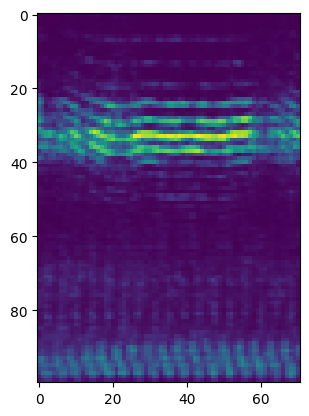

In [21]:
plt.imshow((val_dataset[5][0][0]))

In [8]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x


class AudioClassifierCNN(nn.Module):
    def __init__(self):
        super(AudioClassifierCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            ConvLayer(1, 16),
            ConvLayer(16, 32),
            ConvLayer(32, 64),
            ConvLayer(64, 128),
            ConvLayer(128, 256),
            ConvLayer(256, 256)
        )


        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.squeeze(1)

In [9]:
model = AudioClassifierCNN()
a, b = train_dataset[3]
model(a.unsqueeze(0))

tensor([0.4159], grad_fn=<SqueezeBackward1>)

In [10]:
# (To find mean and std for normalization)
if 0:
    mean = []
    std = []
    mean_b = []
    std_b = []
    for a, b in train_dataset:
        mean.append(a.mean((-1,-2)))
        std.append(a.std((-1,-2)))
    print(np.mean(mean, 0))
    print(np.mean(std, 0))

In [11]:
# Paramètre apprentissage
EPOCHS = 20
LEARNING_RATE = 0.001

# Initialiser le modèle, la loss, et l'optimiseur
num_classes = 2  # Ajustez selon vos besoins
model = AudioClassifierCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Entraîner le modèle
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=50, device="cuda", save_dir="checkpoints2", csv_file="valid2.csv")


Epoch 1/50
----------
train Loss: 0.2585 Acc: 0.9038
val Loss: 0.2161 Acc: 0.9196
Model saved to checkpoints2/model_epoch_1.pth
Epoch 2/50
----------
train Loss: 0.2139 Acc: 0.9247
val Loss: 0.1747 Acc: 0.9382
Model saved to checkpoints2/model_epoch_2.pth
Epoch 3/50
----------
train Loss: 0.1972 Acc: 0.9321
val Loss: 0.1415 Acc: 0.9491
Model saved to checkpoints2/model_epoch_3.pth
Epoch 4/50
----------
train Loss: 0.1855 Acc: 0.9351
val Loss: 0.1346 Acc: 0.9515
Model saved to checkpoints2/model_epoch_4.pth
Epoch 5/50
----------
train Loss: 0.1786 Acc: 0.9380
val Loss: 0.1483 Acc: 0.9521
Model saved to checkpoints2/model_epoch_5.pth
Epoch 6/50
----------


KeyboardInterrupt: 

In [12]:
from codecarbon import EmissionsTracker
tracker = EmissionsTracker(allow_multiple_runs=True)

[codecarbon WARNING @ 01:53:44] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 01:53:44] [setup] RAM Tracking...
[codecarbon INFO @ 01:53:44] [setup] CPU Tracking...
[codecarbon WARNING @ 01:53:44] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon INFO @ 01:53:45] CPU Model on constant consumption mode: AMD Ryzen 9 5900X 12-Core Processor
[codecarbon INFO @ 01:53:45] [setup] GPU Tracking...
[codecarbon INFO @ 01:53:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 01:53:45] >>> Tracker's metadata:
[codecarbon INFO @ 01:53:45]   Platform system: Linux-6.1.0-26-amd64-x86_64-with-glibc2.36
[codecarbon INFO @ 01:53:45]   Python version: 3.11.2
[codecarbon INFO @ 01:53:45]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 01:53:45]   Available RAM : 31.259 GB
[codecarbon INFO @ 01:53:45]   CPU count: 24
[codecarbon INFO @ 0

In [19]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    hop_length=512,
    n_mels=100
).cuda()
X_train
model.cuda()
preds = []

tracker.start()
tracker.start_task("inference")
with torch.inference_mode():
    bs=128
    for i in tqdm(range(0, X_test.shape[0], bs)):
        batch = X_test[i:i+bs]
        mel = mel_transform(torch.as_tensor(batch).cuda())
        mel = torch.log10(1+mel)
        #mel_spectrogram = mel_spectrogram[:,:50]
        #mfcc = self.mfcc_transform(waveform).mean(-1).squeeze(0)
        

        # Normaliser le spectrogramme
        mel = (mel - MEAN)/STD
        mel = mel.unsqueeze(1)
        #pred = np.argmax(model(mel).cpu().numpy(), -1)
        pred = torch.sigmoid(model(mel)).cpu().numpy()
        preds.append(pred)
preds = np.concatenate(preds)

emissions_data = tracker.stop_task()
print(emissions_data.energy_consumed * 1000)

[codecarbon WARNING @ 01:55:10] Already started tracking
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 173.09it/s]
[codecarbon INFO @ 01:55:10] Energy consumed for RAM : 0.000160 kWh. RAM Power : 11.722217559814453 W
[codecarbon INFO @ 01:55:10] Energy consumed for all CPUs : 0.000717 kWh. Total CPU Power : 52.5 W
[codecarbon INFO @ 01:55:10] Energy consumed for all GPUs : 0.001315 kWh. Total GPU Power : 238.54231240370862 W
[codecarbon INFO @ 01:55:10] 0.002192 kWh of electricity used since the beginning.


0.05850168950330892


In [20]:
((preds>0.5)==labels_test).sum()/preds.size

np.float64(0.9478174603174603)

In [ ]:
np.save("preds_nn.npy", preds)